In [270]:
import os
from datetime import datetime

import pandas as pd
import numpy as np
from sklearn.metrics import balanced_accuracy_score

from sklearn.cluster import KMeans

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D



sns.set()

In [271]:
datafile="data/hidden_states.csv"
data = pd.read_csv(datafile)
data = data.drop(data[data.DX_mask == 0].index)
data = data.dropna(subset=["DXCHANGE"])
data.DXCHANGE = data.DXCHANGE.astype(int)

#data.DXCHANGE = data.DXCHANGE.where(data.DXCHANGE > 3, 0)
#data = data.drop(data[data.DXCHANGE == 0].index)
#data.DXCHANGE = data.DXCHANGE.where(data.DXCHANGE < 4, 1)
x = data.iloc[:,3:131]
data

,RID,TP,DX,DX_mask,hidden_0,hidden_1,hidden_2,hidden_3,hidden_4,hidden_5,...,hidden_120,hidden_121,hidden_122,hidden_123,hidden_124,hidden_125,hidden_126,hidden_127,cluster,DXCHANGE
0,2.0,6.0,0.0,1.0,-0.326462,0.013623,-0.121340,-0.061322,0.174480,0.429307,...,0.621976,-0.444028,0.072976,0.679904,-0.413200,0.108640,0.235828,-0.135060,3,1
5,2.0,36.0,0.0,1.0,-0.125128,0.167353,-0.435139,-0.155267,0.116786,0.740306,...,0.693898,-0.706921,0.321557,0.699811,-0.585326,0.470130,0.478737,-0.699555,3,1
9,2.0,60.0,0.0,1.0,-0.095401,0.172916,-0.519267,-0.139745,0.388942,0.631461,...,0.585240,-0.406028,0.270438,0.762265,-0.513358,0.644465,0.268194,-0.023257,0,1
11,2.0,72.0,0.0,1.0,-0.236064,0.236268,-0.592743,-0.169090,-0.034059,0.667493,...,0.711972,-0.682365,0.236683,0.788078,-0.509573,0.623525,0.429417,-0.485595,0,1
13,2.0,84.0,1.0,1.0,-0.137920,0.320162,-0.426267,-0.111352,0.013424,0.713440,...,0.662367,-0.670622,0.537434,0.690469,-0.663881,0.595498,0.505347,-0.439472,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9385,5290.0,6.0,0.0,1.0,-0.224710,0.007555,-0.136876,-0.035858,0.379966,0.339668,...,0.272492,-0.138853,-0.028540,0.710402,-0.268383,0.002763,0.302431,-0.343949,3,1
9388,5290.0,24.0,0.0,1.0,-0.013557,-0.009722,-0.193552,-0.271508,0.503671,0.694189,...,0.376807,-0.292157,-0.112678,0.825802,-0.521940,-0.013688,0.464258,-0.566406,3,1
9392,5294.0,24.0,0.0,1.0,-0.043405,-0.003036,-0.279255,-0.215493,0.539554,0.698843,...,0.696900,-0.445502,-0.065378,0.539572,-0.561894,0.037776,0.402366,-0.670824,3,1
9396,5295.0,24.0,0.0,1.0,-0.289028,0.008362,-0.355723,-0.107229,0.252775,0.423591,...,0.548213,-0.535705,-0.229536,0.497513,-0.338534,0.162906,0.313946,-0.592688,3,1


In [272]:
"""
This method clusters hidden states independently of any classification task
This is just to extract the data from the latent space and perform visualizations
"""
def cluster(hidden_states, n_prototypes, hidden_size=128, extra_fields=["DXCHANGE"]):
    model = KMeans(n_clusters=n_prototypes, init="k-means++")
    batch_x = pd.read_csv(hidden_states)
    batch_x = batch_x.drop(batch_x[batch_x.DX_mask == 0].index)
    batch_x = batch_x.dropna(subset=extra_fields)
    batch_x.DXCHANGE = batch_x.DXCHANGE.astype(int)
    hiddens = batch_x.to_numpy()[:,4:4+hidden_size]
    model.fit(hiddens)
    batch_x["cluster"] = model.labels_
    return batch_x, model

In [273]:
def _parallel_compute_distance(x, cluster):
    n_samples = x.shape[0]
    dis_mat = np.zeros((n_samples, 1))
    for i in range(n_samples):
        dis_mat[i] += np.sqrt(np.sum((x.iloc[i] - cluster) ** 2, axis=0))
    return dis_mat

In [312]:
def get_prototypes(model, n_prototypes, batch_x):
    centers = model.cluster_centers_
    prototype_list = [None]*n_prototypes
    for pr in range(n_prototypes):
        # Only get time points that exist (not imputed values, check cat mask)
        mask = (np.array(model.labels_) == pr)  & (batch_x.DXCHANGE >3)
        assigned = batch_x[mask]
        dist_mat = _parallel_compute_distance(assigned.iloc[:, 12:140], centers[pr])
        closest_dp = np.argmin(dist_mat)
        rid = assigned.iloc[closest_dp, 0]
        tp = assigned.iloc[closest_dp, 1]
        hidden = assigned.iloc[closest_dp, 2:]
        prototype_list[pr] = [int(rid), int(tp), hidden]
    prototype_hidden = (tup[2] for tup in prototype_list)
    prototype_hidden = np.vstack(prototype_hidden)
    prototype_hidden = np.array(prototype_hidden)
    return prototype_list

In [302]:
datafile = "data/ae_hidden_states/fold_0_hidden_states.csv"
n_prototypes = 4

(data, model) = cluster(datafile, n_prototypes, extra_fields=["TP","DXCHANGE", "AGE", "MMSE", "ABETA_UPENNBIOMK9_04_19_17", "PTGENDER"])
prototypes = get_prototypes(model, n_prototypes, data)


prototypes

data["cluster"] = model.labels_


data.DXCHANGE = data.DXCHANGE.where(data.DXCHANGE == 5, 0)
data = data.drop(data[data.DXCHANGE == 0].index)
data

x = data.iloc[:,4:132]

/home/moyde/Documents/Studies/Chalmers/Thesis/LIPTraAD/venv/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  from ipykernel import kernelapp as app


In [303]:

pca = PCA(n_components=4)
pca_result = pca.fit_transform(x.values)
pca_result = pd.DataFrame({"RID":data["RID"], "TP":data["TP"],"PCA-0":pca_result[:,0], "PCA-1":pca_result[:,1], "PCA-2":pca_result[:,2], "DX":data["DX"], 
                           "DXCHANGE":data["DXCHANGE"], "cluster":data["cluster"],
                            "AGE":data["AGE"], "MMSE":data["MMSE"],
                            "ABETA_UPENNBIOMK9_04_19_17":data["ABETA_UPENNBIOMK9_04_19_17"], "PTGENDER":data["PTGENDER"]})
print(pca_result.shape)
print(x.shape)
pca_result

(60, 12)
(60, 128)


,RID,TP,PCA-0,PCA-1,PCA-2,DX,DXCHANGE,cluster,AGE,MMSE,ABETA_UPENNBIOMK9_04_19_17,PTGENDER
13,42.0,12.0,-0.646791,0.989669,-0.363974,2.0,5,3,72.8,24.0,766.5,Male
93,4243.0,24.0,0.400117,-1.631188,0.063945,2.0,5,3,79.3,19.0,977.7,Male
223,778.0,72.0,-1.200275,0.146790,0.445271,2.0,5,3,72.4,25.0,626.2,Male
618,331.0,36.0,0.566389,0.514604,-0.606345,2.0,5,3,64.6,23.0,486.1,Female
668,376.0,48.0,-1.260430,0.143236,-0.115072,2.0,5,3,70.5,28.0,1492.0,Male
730,1073.0,36.0,1.242572,0.517089,-0.575780,2.0,5,3,65.7,21.0,700.1,Female
861,1213.0,12.0,0.688775,-0.232900,0.207726,2.0,5,3,74.8,23.0,469.6,Female
1117,4250.0,24.0,0.013447,-1.510305,0.119671,2.0,5,3,78.5,21.0,584.6,Male
1502,2087.0,48.0,-0.373024,0.021420,0.052380,2.0,5,3,69.5,21.0,414.7,Male
1594,429.0,12.0,-2.514105,-0.471296,0.212634,2.0,5,3,62.7,25.0,1139.0,Male


In [304]:
pca_result = pd.concat([pca_result, x], axis=1)
pca_result.DXCHANGE = pca_result.DXCHANGE.where(pca_result.DXCHANGE == 5, 0)
pca_result = pca_result.drop(pca_result[pca_result.DXCHANGE == 0].index)

mapping = {
    0:"No Change",
    1:"CN",
    2:"MCI",
    3:"AD",
    4:"CN-MCI",
    5:"MCI-AD",
    6:"CN-AD",
    7:"MCI-CN",
    8:"AD-MCI"
}
pca_result.DXCHANGE = pca_result.DXCHANGE.map(mapping)
pca_result

,RID,TP,PCA-0,PCA-1,PCA-2,DX,DXCHANGE,cluster,AGE,MMSE,...,hidden_118,hidden_119,hidden_120,hidden_121,hidden_122,hidden_123,hidden_124,hidden_125,hidden_126,hidden_127
13,42.0,12.0,-0.646791,0.989669,-0.363974,2.0,MCI-AD,3,72.8,24.0,...,0.092264,-0.219202,0.086881,0.047350,0.051126,-0.216182,-0.143730,-0.200672,0.258463,-0.085181
93,4243.0,24.0,0.400117,-1.631188,0.063945,2.0,MCI-AD,3,79.3,19.0,...,-0.125756,-0.339802,0.470410,-0.078180,0.380680,-0.439105,-0.313701,-0.353791,-0.266717,-0.248874
223,778.0,72.0,-1.200275,0.146790,0.445271,2.0,MCI-AD,3,72.4,25.0,...,-0.077141,-0.154331,0.097235,-0.073725,0.076848,-0.100002,-0.182570,-0.085180,-0.201736,-0.064341
618,331.0,36.0,0.566389,0.514604,-0.606345,2.0,MCI-AD,3,64.6,23.0,...,0.020844,-0.328152,0.217846,-0.051438,0.158373,-0.364771,-0.207491,-0.357369,0.482810,-0.209185
668,376.0,48.0,-1.260430,0.143236,-0.115072,2.0,MCI-AD,3,70.5,28.0,...,0.060426,-0.201630,0.120737,0.058425,0.082910,-0.177655,-0.218002,-0.135379,-0.149036,-0.050049
730,1073.0,36.0,1.242572,0.517089,-0.575780,2.0,MCI-AD,3,65.7,21.0,...,-0.035898,-0.359604,0.271480,-0.116460,0.213259,-0.420834,-0.222473,-0.424951,0.638679,-0.286283
861,1213.0,12.0,0.688775,-0.232900,0.207726,2.0,MCI-AD,3,74.8,23.0,...,-0.110191,-0.267317,0.337594,-0.144319,0.282839,-0.370007,-0.183425,-0.343402,0.133858,-0.271787
1117,4250.0,24.0,0.013447,-1.510305,0.119671,2.0,MCI-AD,3,78.5,21.0,...,-0.126838,-0.310304,0.402505,-0.085377,0.322102,-0.368279,-0.350707,-0.295121,-0.309004,-0.204178
1502,2087.0,48.0,-0.373024,0.021420,0.052380,2.0,MCI-AD,3,69.5,21.0,...,-0.071323,-0.225967,0.182460,-0.089041,0.141672,-0.211480,-0.250712,-0.208282,0.063152,-0.126058
1594,429.0,12.0,-2.514105,-0.471296,0.212634,2.0,MCI-AD,3,62.7,25.0,...,0.036155,-0.116255,0.112869,0.138824,0.063297,-0.034026,-0.252281,0.046548,-0.571402,0.086032


In [305]:
pca.explained_variance_ratio_

array([0.68161197, 0.25223137, 0.05141379, 0.00913764])

In [314]:
model = KMeans(n_clusters=2, init="k-means++")
x = pca_result.iloc[:,12:]
model.fit(x)
pca_result["cluster"] = model.labels_
pca_result.DXCHANGE = 5
prototypes = get_prototypes(model, 2, pca_result)
prototypes

/home/moyde/Documents/Studies/Chalmers/Thesis/LIPTraAD/venv/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  from ipykernel import kernelapp as app


[[872,
  60,
  PCA-0          -1.41801
  PCA-1         -0.145676
  PCA-2        -0.0253701
  DX                    2
  DXCHANGE              5
                  ...    
  hidden_123    -0.140899
  hidden_124    -0.223746
  hidden_125   -0.0923008
  hidden_126    -0.230357
  hidden_127   -0.0309509
  Name: 5287, Length: 138, dtype: object],
 [4015,
  24,
  PCA-0          1.07404
  PCA-1         0.106267
  PCA-2         -0.33748
  DX                   2
  DXCHANGE             5
                  ...   
  hidden_123   -0.411538
  hidden_124   -0.226845
  hidden_125   -0.408391
  hidden_126    0.446456
  hidden_127   -0.281419
  Name: 8215, Length: 138, dtype: object]]

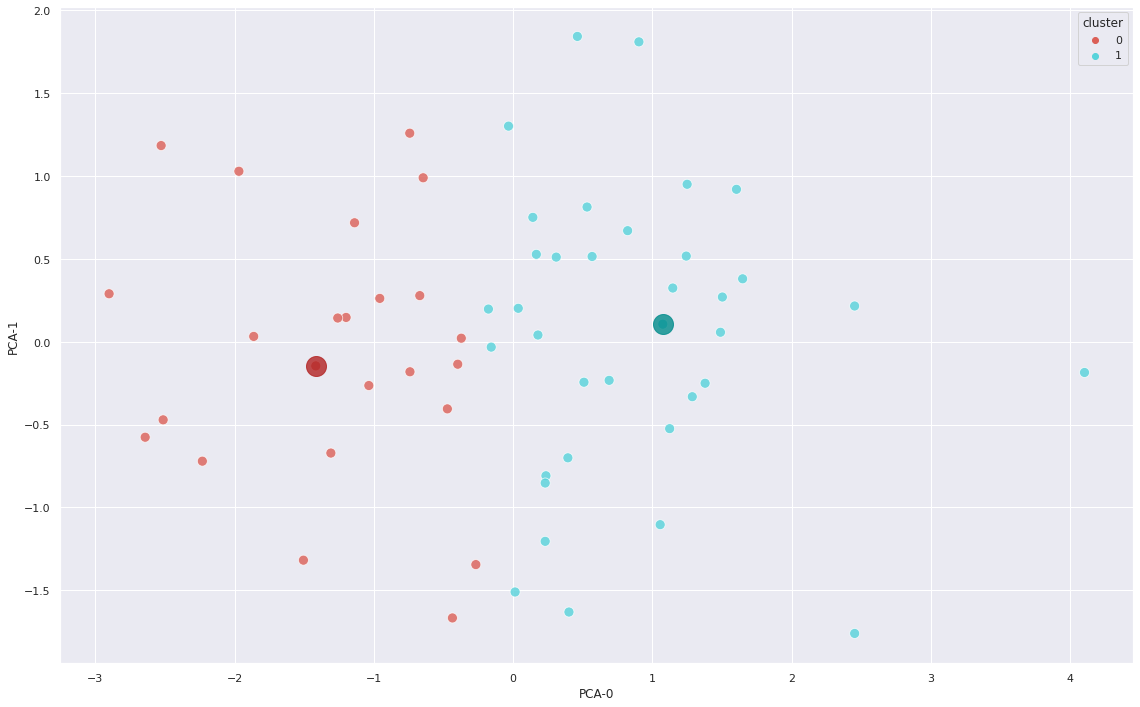

In [336]:
plt.figure(figsize=(16,10))
ax = sns.scatterplot(
    x="PCA-0", y="PCA-1",
    hue="cluster",   
    s = 100,
    palette=sns.color_palette("hls", 2),
    data=pca_result,
    legend="full",
    alpha=0.8
)
ax.plot([prototypes[0][2][0]], [prototypes[0][2][1]], 'firebrick',marker="o", markersize=20, alpha=0.8)
ax.plot(prototypes[1][2][0], prototypes[1][2][1], 'darkcyan', marker="o", markersize=20,alpha=0.8)
#ax.get_legend().remove()
plt.tight_layout()
plt.savefig("figures/ae/hidden_states_pca_color_cluster_mci_ad_clustering.png")


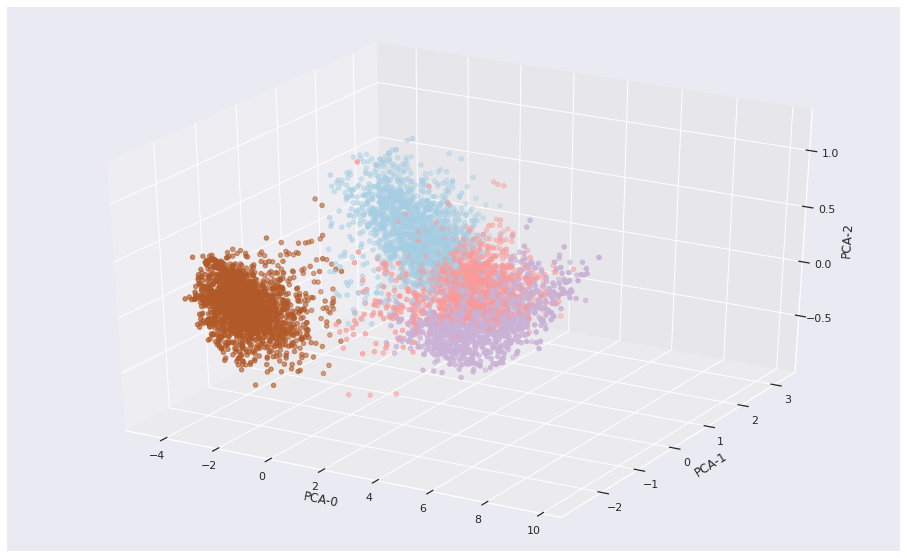

In [52]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=pca_result["PCA-0"],
    ys=pca_result["PCA-1"],
    zs=pca_result["PCA-2"],
    c=pca_result["cluster"], 
    cmap='Paired'
)
ax.set_xlabel('PCA-0')
ax.set_ylabel('PCA-1')
ax.set_zlabel('PCA-2')
plt.savefig("figures/ae/hidden_states_pca_color_cluster4_3d.png")